In [1]:
import scanpy as sc
#import anndata as AN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [48]:
# load data
meta = np.load('./processed_data/single_cell/filtered_meta.npy', allow_pickle=True)
meta_names = np.load('./processed_data/single_cell/meta_names.npy', allow_pickle=True)
features = np.load('./processed_data/single_cell/features.npy')
counts = np.memmap('./processed_data/single_cell/filtered_counts.npy', mode='r+', shape=(meta.shape[0], features.shape[0]), dtype='int16')
marker_indices = np.load('./processed_data/single_cell/marker_indices.npy')

In [49]:
# subset
index = meta[:,np.where(meta_names=='keep_cells_all_per_celltype')[0][0]].astype(bool)
index2 = meta[:,np.where(meta_names=='keep_cells_gaussian')[0][0]].astype(bool)
index_all = index&index2

META = meta[index_all]
COUNTS = counts[index_all]#[:,marker_indices]

META_df = pd.DataFrame(META)
META_df.columns = meta_names
META_df.index = META_df['barcodes']

META_df['total_counts'] = META_df['total_counts'].astype(int)
META_df['mito_fractions'] = META_df['mito_fractions'].astype(float)

FEATURES_df = pd.DataFrame(features)#[marker_indices])
FEATURES_df.columns = ['Gene', 'ID']
FEATURES_df.index = FEATURES_df['Gene']

COUNTS_df = pd.DataFrame(COUNTS)
COUNTS_df.columns = FEATURES_df['Gene']
COUNTS_df.index = META_df['barcodes']

META_df = pd.get_dummies(META_df, columns=['seq_batch'], drop_first=True)

In [50]:
# make adata
adata = sc.AnnData(X=COUNTS, obs=META_df, var=FEATURES_df)
adata.uns['metadata'] = META_df
adata.var_names_make_unique(join='.')
adata.obs_names_make_unique(join='.')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [51]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

In [55]:
sc.pp.regress_out(adata, ['total_counts', 'mito_fractions', 'seq_batch_JBM'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


In [56]:
sc.pp.neighbors(adata)
sc.tl.leiden(adata, resolution=0.5)

In [57]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_paga.py:235: RuntimeWarning: divide by zero encountered in true_divide
  inverse_connectivities.data = 1.0 / inverse_connectivities.data
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/gridsan/djuna/.local/lib/python3.8/site-packages/umap/umap_.py:919: RuntimeWarning: divide by zero encountered in true_divide
  result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


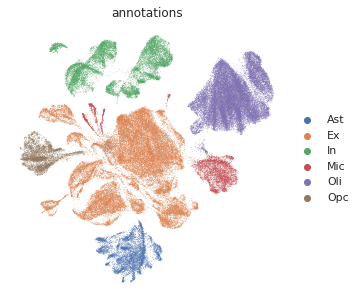

In [58]:
out = sc.pl.umap(adata, color=['annotations'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)
    

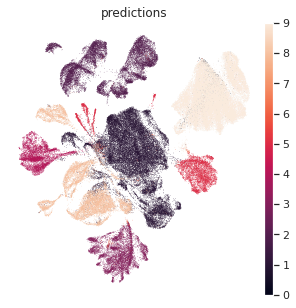

In [59]:
out = sc.pl.umap(adata, color=['predictions'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


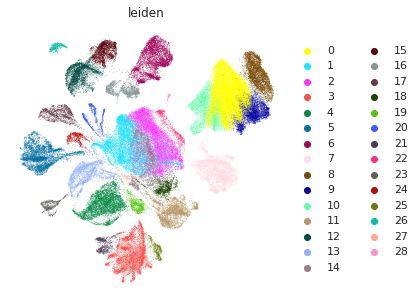

In [60]:
out = sc.pl.umap(adata, color=['leiden'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [61]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')


/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is h

In [74]:
markers = pd.read_csv('./processed_data/single_cell/brain_marker_genes.csv')
markers.head()

,Unnamed: 0,marker,major_celltype
0,Ast.1,ABLIM1,Ast
1,Ast.2,AC002429.2,Ast
2,Ast.3,AC008957.2,Ast
3,Ast.4,AC074363.1,Ast
4,Ast.5,ACOT11,Ast


In [75]:
scores = adata.uns['rank_genes_groups']['scores']
names = adata.uns['rank_genes_groups']['names']
sele_genes = np.array(pd.DataFrame(names)).T
sele_scores = np.array(pd.DataFrame(scores)).T

In [76]:
celltypes = np.unique(markers['major_celltype'])
celltype_scores = np.empty(shape=(sele_scores.shape[0], len(celltypes)))

for cluster in range(sele_scores.shape[0]):
    for i in range(len(celltypes)):
        mark = np.array(markers[markers['major_celltype']==np.unique(celltypes)[i]]['marker'])    
        dictionary = dict(zip(sele_genes[cluster], sele_scores[cluster]))
        S = np.mean([dictionary[x] for x in mark if x in set(dictionary.keys()) ])
        celltype_scores[cluster][i] = S 

In [77]:
assignments = np.array([celltypes[np.argmax(x)] for x in celltype_scores])
dictionary = dict(zip(np.arange(len(assignments)), assignments))
adata.obs['Assignment'] = [dictionary[int(x)] for x in np.array(adata.obs['leiden'])]

/home/gridsan/djuna/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


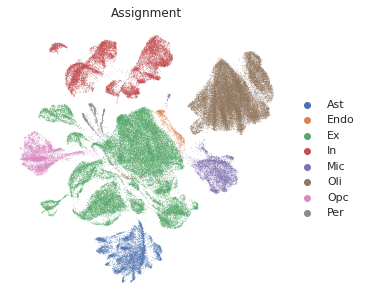

In [78]:
import seaborn as sns
width = 5
height = 5
sns.set(rc = {'figure.figsize':(width, height)})
out = sc.pl.umap(adata, color=['Assignment'], add_outline=False, frameon=False, gene_symbols='Gene', return_fig=True)


In [35]:
np.unique(adata.obs['Assignment'], return_counts=True)

(array(['Ast', 'B cells', 'Endo', 'Ex', 'In', 'Mic', 'Oli', 'Opc', 'Per',
        'T cells'], dtype=object),
 array([ 8081,   100,   366, 42019, 14634,  5264, 31723,  5855,   719,
          946]))

In [79]:
import matplotlib.pyplot as plt
cm = plt.cm.get_cmap('tab20')
colors = [cm(int(x)) for x in range(len(np.unique(assignments)))]
dictionary = dict(zip(np.unique(assignments), colors))

/state/partition1/slurm_tmp/23505678.0.0/ipykernel_44200/2153427995.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


/home/gridsan/djuna/.local/lib/python3.8/site-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


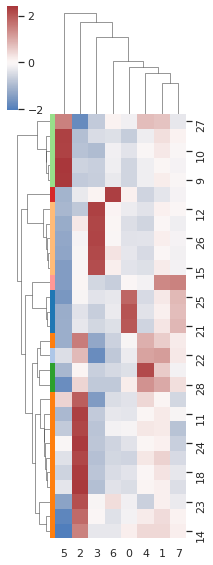

In [80]:
sns.clustermap(celltype_scores, row_colors = [dictionary[x] for x in assignments], z_score=0, cmap="vlag", center=0, figsize=(3,8))

In [82]:
np.save('./processed_data/single_cell/annotations.npy', adata.obs['Assignment'])
np.save('./processed_data/single_cell/leiden.npy', adata.obs['leiden'])
np.save('./processed_data/single_cell/scores.npy', celltype_scores)

In [ ]:
# save the coordinates